In [1]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt

def unit_range_fixed(x, L=1, eps=1e-9):
    y = x.copy()
    y = y % L
    y[(np.fabs(y) < eps) | (np.fabs(L - y) < eps)] = 0
    return y
# from calculations.order_parameter import calculate_order_parameter
# from calculations.disregistry import calculate_disregistry
# from plots.order_parameter_plots import plot_order_parameter_cut, plot_order_parameter_top_down
# from plots.disregistry_plots import plot_disregistry_scatter


# File paths (replace with your actual file paths)
unrelaxed_file = 'MoS2_WSe2_1D.xyz'
relaxed_file = 'MoS2_WSe2_1D_lammps.traj.xyz'

# Read structures
unrelaxed = read(unrelaxed_file, index= 0)
relaxed = read(relaxed_file, index= -1)
relaxed.arrays['atom_types'] = unrelaxed.arrays['atom_types']


# Define A1 and A2 unit cells (replace with your actual unit cell matrices)
def convert_string_to_array(string):
    # Remove brackets and split the string into components
    return np.array([float(x) for x in string.strip('[]').split()]).reshape(2,2)
A1 = convert_string_to_array(unrelaxed.info['base_lattice_0'])
A2 = convert_string_to_array(unrelaxed.info['base_lattice_1'])

# # Calculate disregistry vectors
# disregistry_relaxed = calculate_disregistry(relaxed, A1, A2)
# disregistry_unrelaxed = calculate_disregistry(unrelaxed, A1, A2)

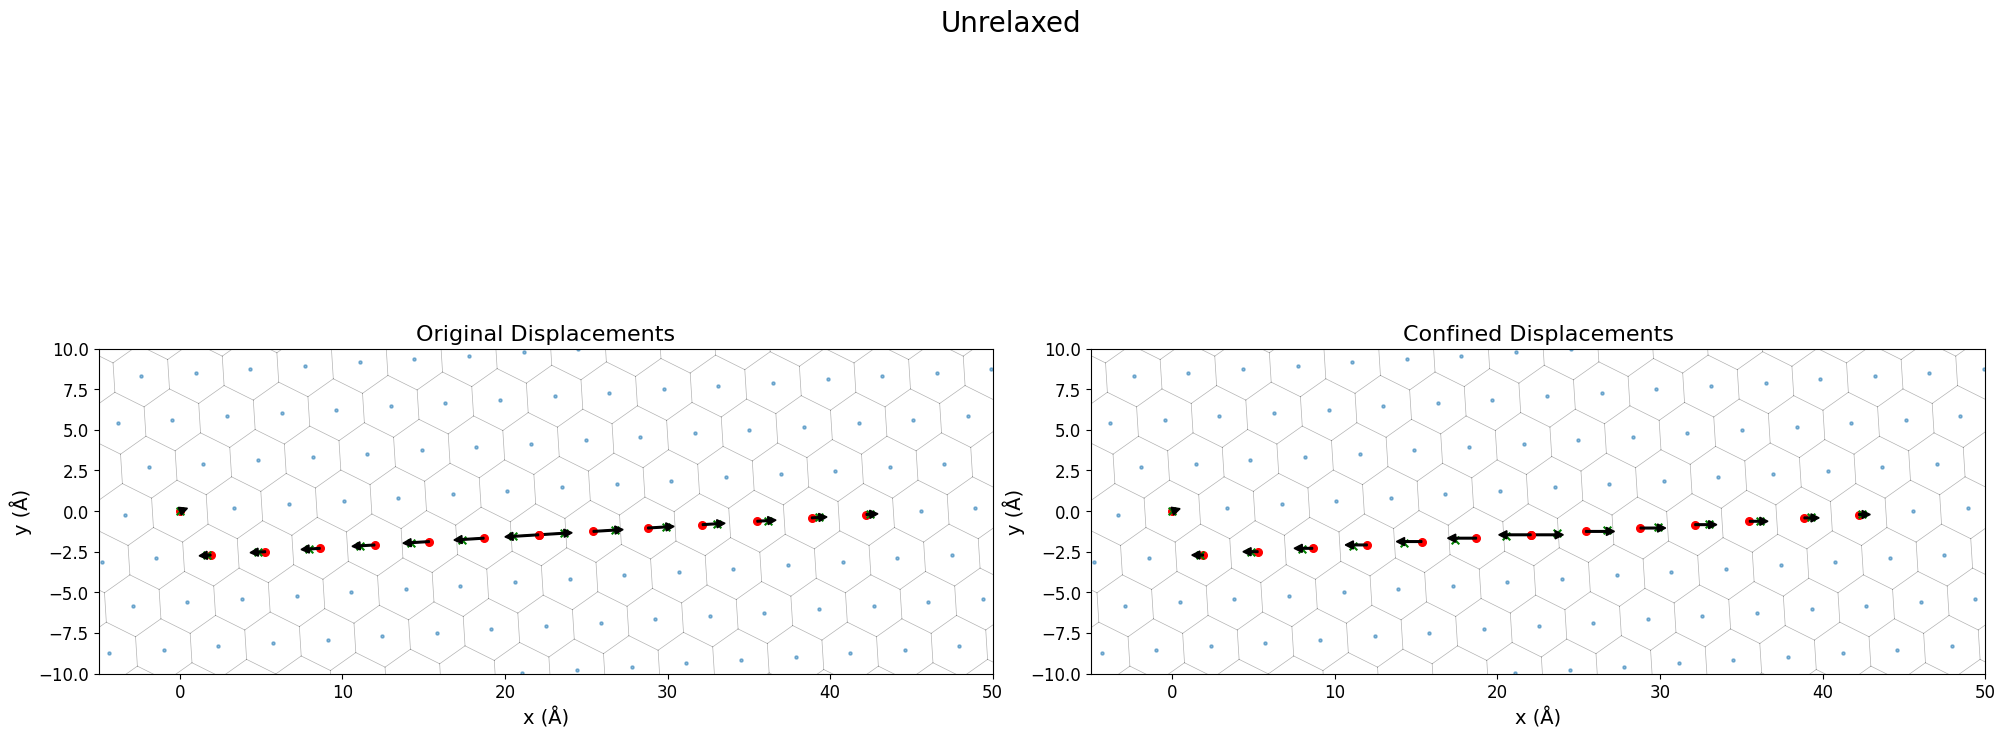

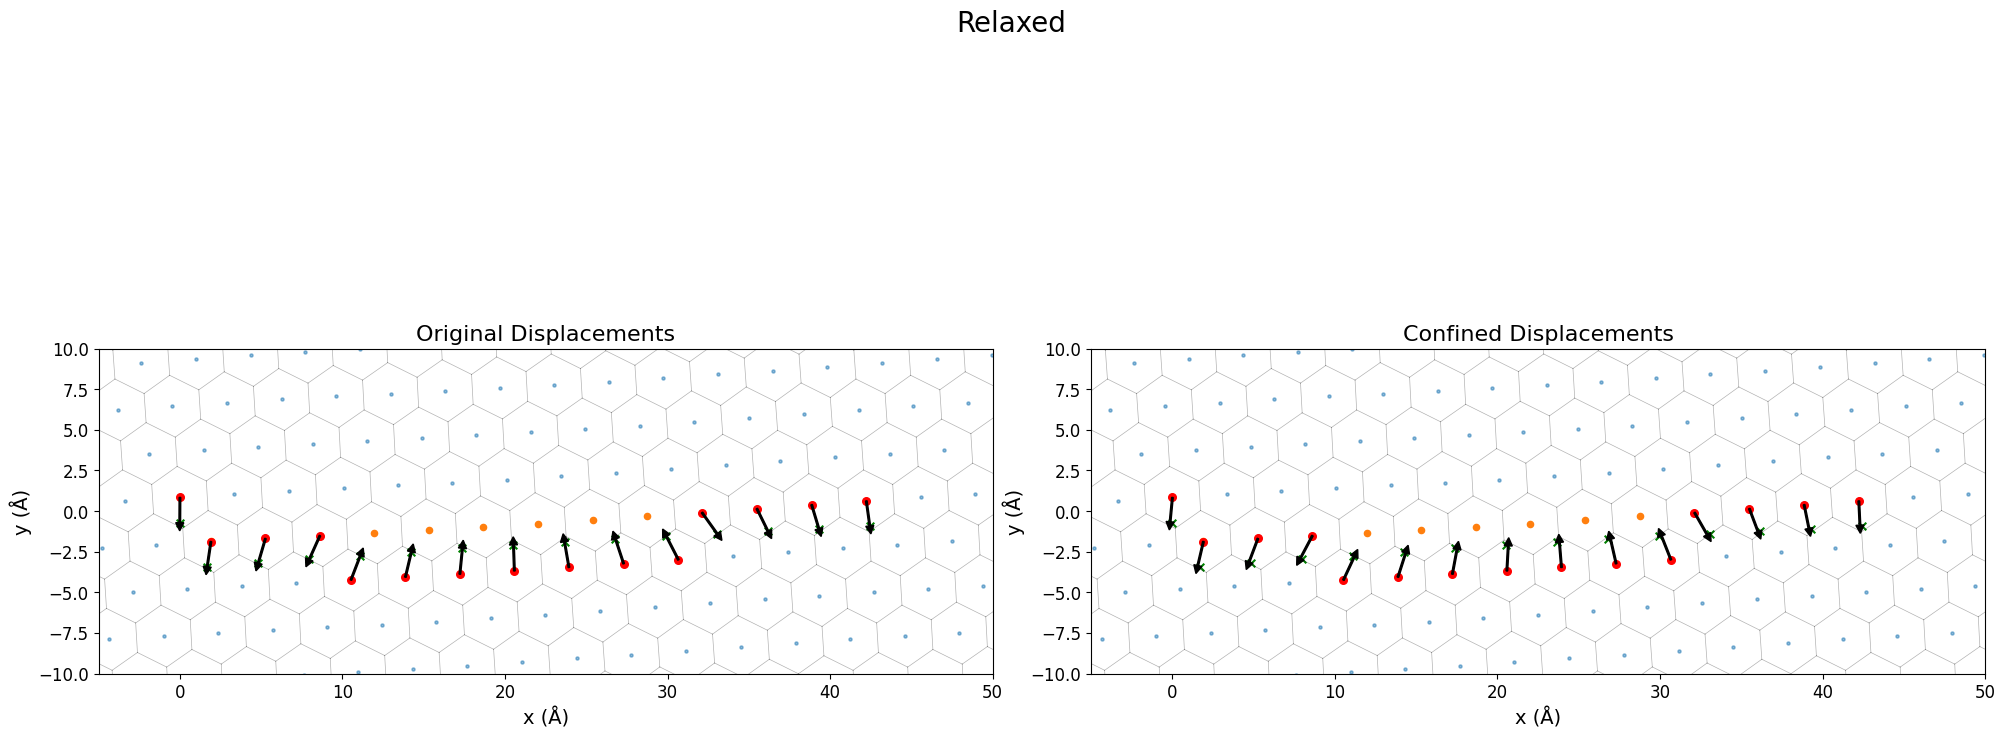

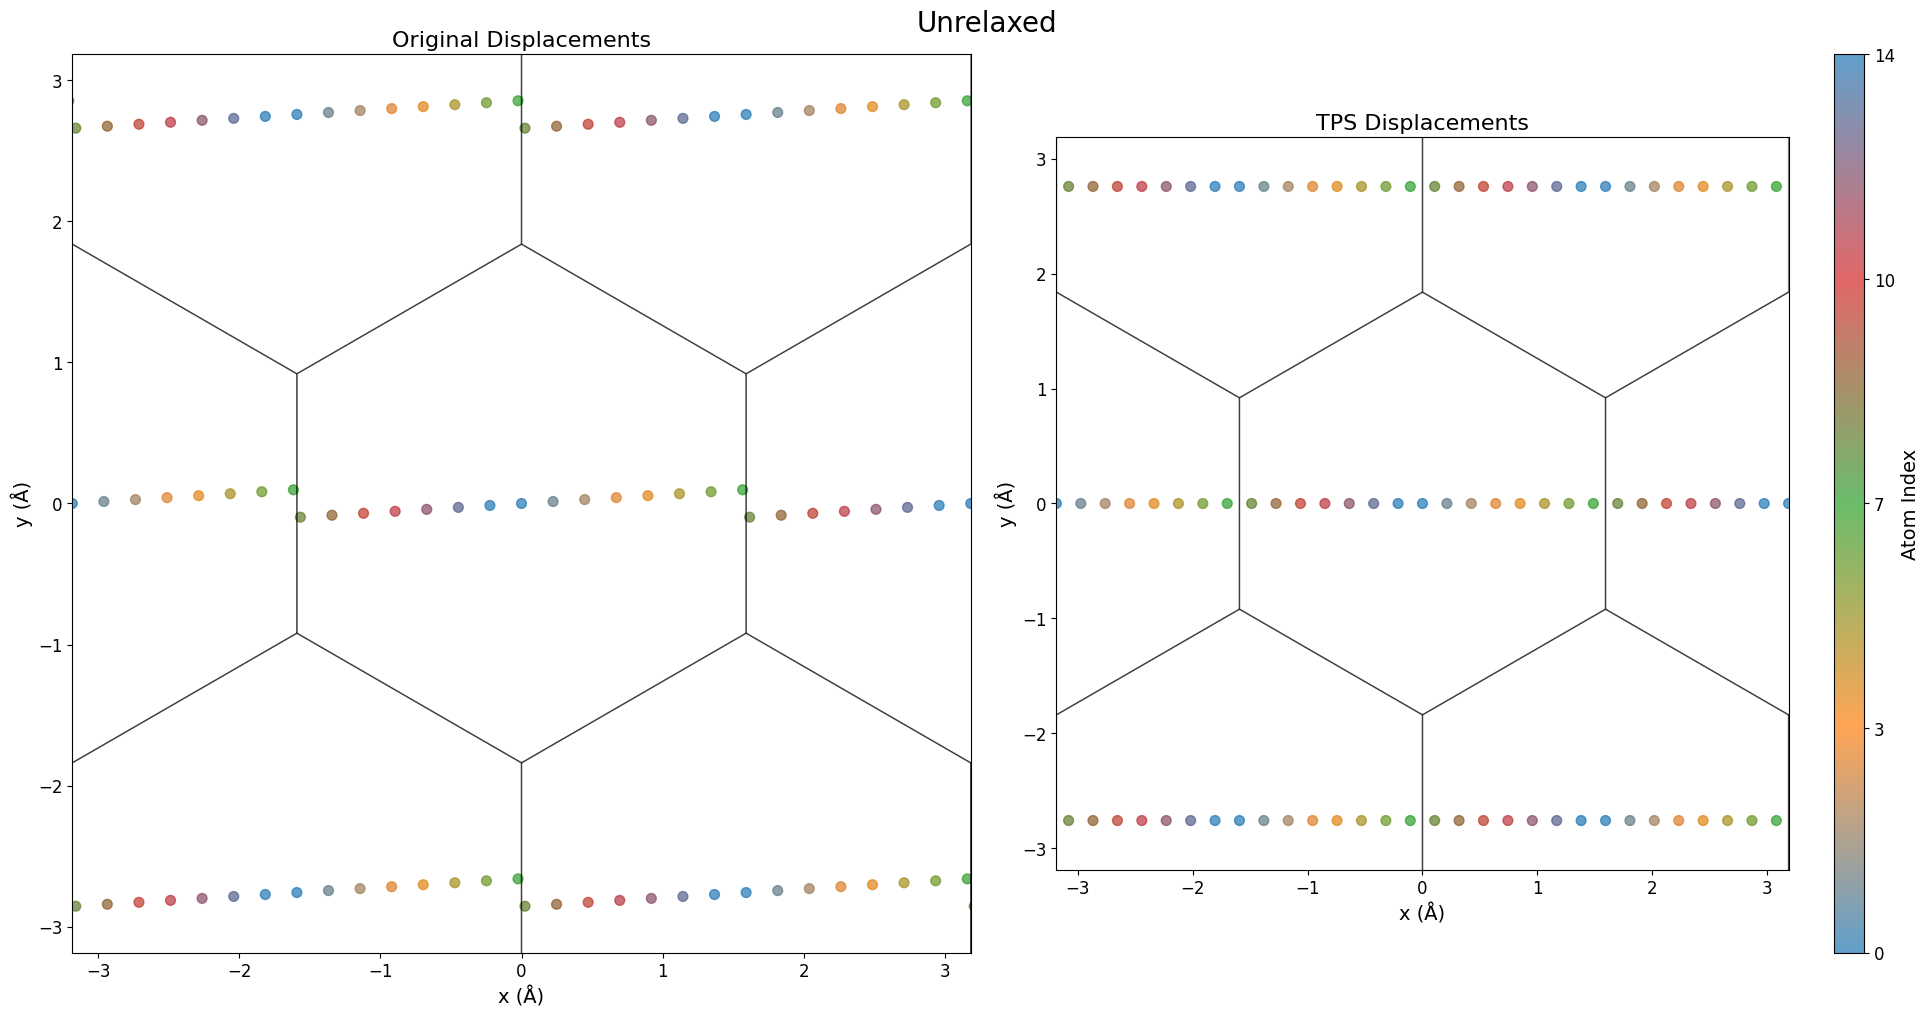

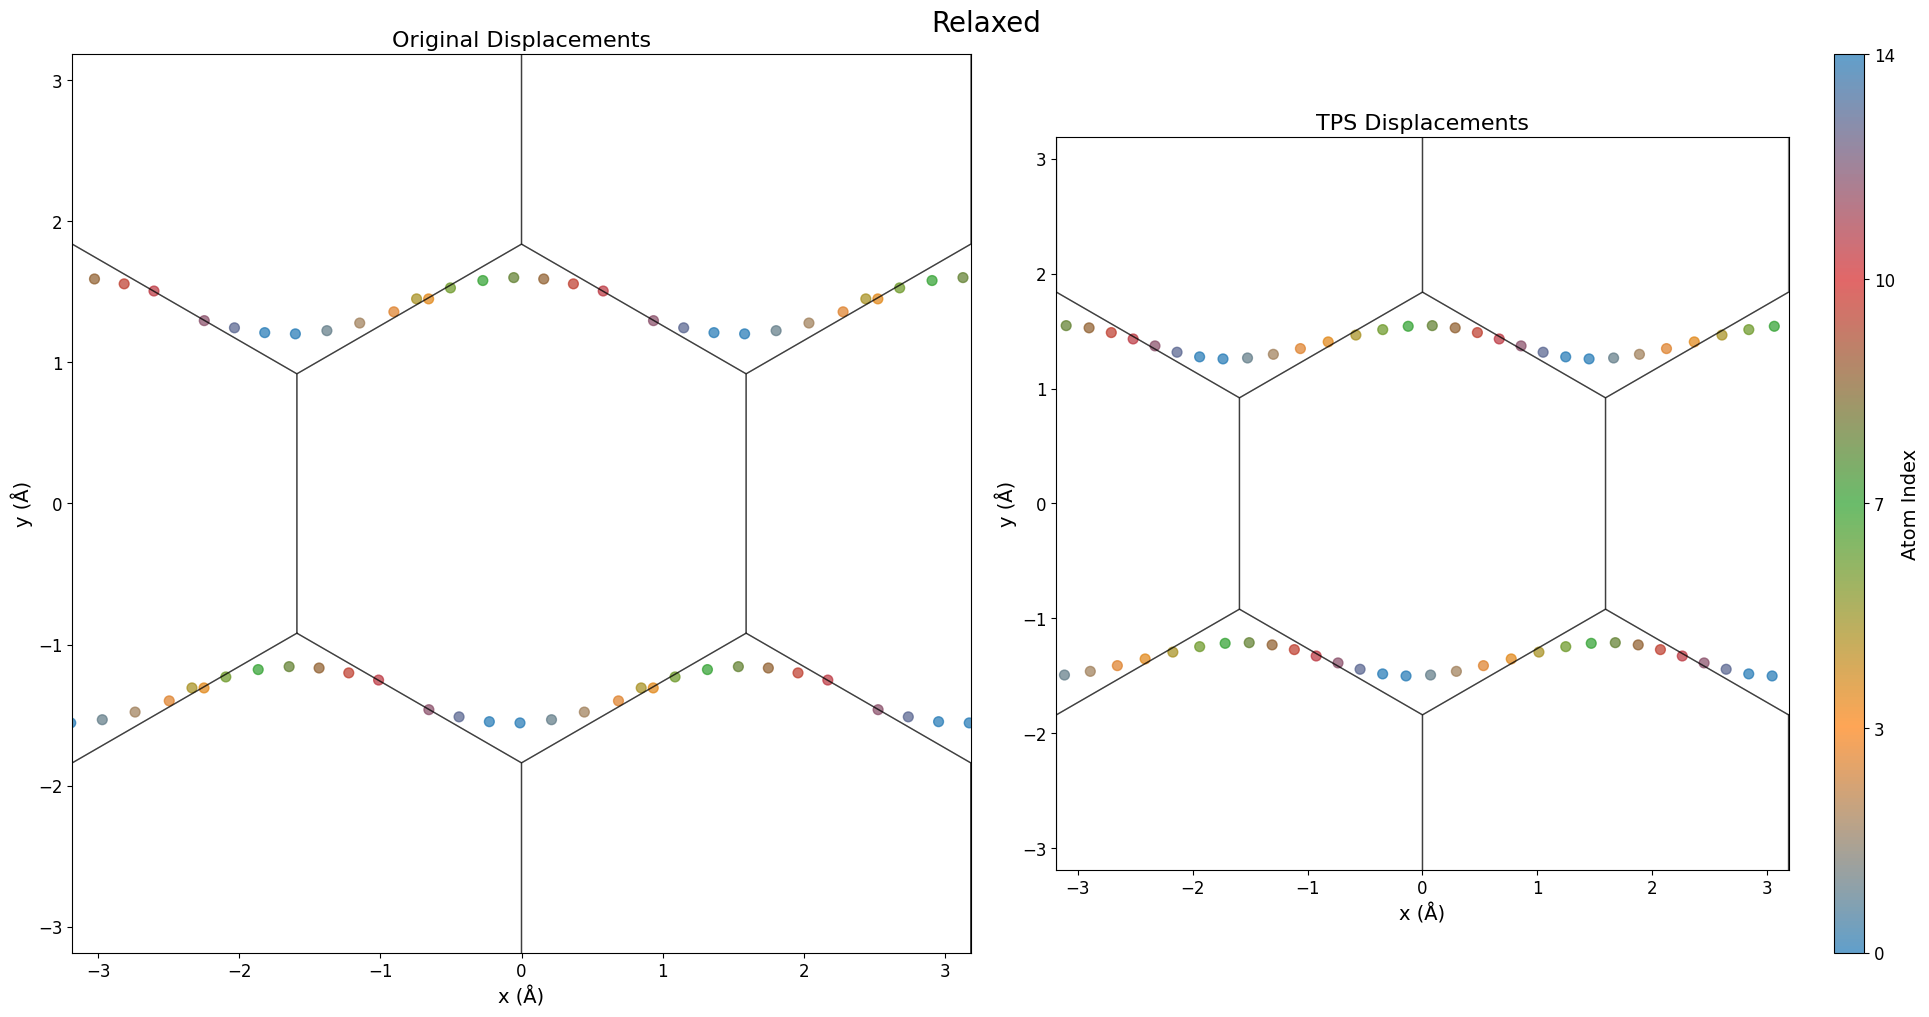

In [2]:
import numpy as np
from scipy.spatial import Voronoi, cKDTree
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.interpolate import RBFInterpolator
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

def plot_voronoi_diagram(ax, vor, xlim, ylim):
    """
    Plot Voronoi diagram within specified limits.
    """
    for simplex in vor.ridge_vertices:
        if simplex[0] >= 0 and simplex[1] >= 0:
            vertices = vor.vertices[simplex]
            if np.all((vertices[:, 0] >= xlim[0]) & (vertices[:, 0] <= xlim[1]) &
                      (vertices[:, 1] >= ylim[0]) & (vertices[:, 1] <= ylim[1])):
                ax.plot(vertices[:, 0], vertices[:, 1], 'k-', linewidth=0.5, alpha=0.3)

def get_primitive_voronoi_cell(A1):
    x, y = np.meshgrid([-1, 0, 1], [-1, 0, 1])
    points = np.column_stack((x.ravel(), y.ravel()))
    lattice_points = points @ A1
    vor = Voronoi(lattice_points)
    central_point_index = 4
    central_region = vor.regions[vor.point_region[central_point_index]]
    if -1 not in central_region:
        return vor.vertices[central_region]
    return None

def pad_periodic_image(pos, box):
    """
    Pad the periodic image of a structure in both the a1 and a2 directions to make a 3x3 super cell.
    """
    n_a1, n_a2 = 2, 10
    i_range = np.concatenate((np.arange(0, n_a1+1), np.arange(-n_a1, 0)))
    j_range = np.concatenate((np.arange(0, n_a2+1), np.arange(-n_a2, 0)))
    
    i, j = np.meshgrid(i_range, j_range)
    i, j = i.flatten(), j.flatten()
    
    offsets = i[:, np.newaxis] * box[0] + j[:, np.newaxis] * box[1]
    padded_pos = pos[np.newaxis, :, :] + offsets[:, np.newaxis, :]
    
    return np.vstack((pos, padded_pos[1:].reshape(-1, 2)))

def calculate_voronoi_and_displacement(padded_positions, query_points, A1):
    points_2d = padded_positions[:, :2]
    vor = Voronoi(points_2d)
    tree = cKDTree(points_2d)
    
    pristine_cell = get_primitive_voronoi_cell(A1)
    
    _, nearest_indices = tree.query(query_points)
    region_indices = vor.point_region[nearest_indices]
    
    centroids = []
    for region_index in region_indices:
        region = vor.regions[region_index]
        if -1 not in region:
            cell_vertices = vor.vertices[region]
            centroid = np.mean(cell_vertices, axis=0)
        else:
            centroid = points_2d[nearest_indices[len(centroids)]]
        centroids.append(centroid)
    
    centroids = np.array(centroids)
    displacements = query_points - centroids
    
    confined_displacements = np.array([confine_displacement(disp, vor.vertices[vor.regions[region_index]], pristine_cell) 
                                       for disp, region_index in zip(displacements, region_indices)])
    
    return vor, centroids, displacements, confined_displacements

def confine_displacement(displacement, actual_cell, pristine_cell):
    actual_centroid = np.mean(actual_cell, axis=0)
    pristine_centroid = np.mean(pristine_cell, axis=0)
    
    actual_cell_centered = actual_cell - actual_centroid
    pristine_cell_centered = pristine_cell - pristine_centroid
    
    cost_matrix = cdist(actual_cell_centered, pristine_cell_centered)
    _, col_ind = linear_sum_assignment(cost_matrix)
    
    pristine_cell_matched = pristine_cell[col_ind]
    
    tps = RBFInterpolator(actual_cell, pristine_cell_matched, kernel='thin_plate_spline', smoothing=0)
    
    start_point = actual_centroid
    end_point = start_point + displacement
    
    transformed_points = tps(np.vstack((start_point, end_point)))
    confined_displacement = transformed_points[1] - transformed_points[0]
    
    return confined_displacement


import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

def visualize_structure(padded_positions, positions, query_points, A1, title):
    vor, centroids, displacements, confined_displacements = calculate_voronoi_and_displacement(padded_positions, query_points, A1)
    
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    for ax, disp, subtitle in zip([ax1, ax2], [displacements, confined_displacements], ['Original', 'Confined']):
        plot_voronoi_diagram(ax, vor, xlim=(-10, 100), ylim=(-20, 20))
        ax.scatter(padded_positions[:,0], padded_positions[:,1], s=5, alpha=0.5)
        ax.scatter(positions[:,0], positions[:,1], s=20)

        for centroid, query_point, displacement in zip(centroids, query_points, disp):
            ax.scatter(centroid[0], centroid[1], c='r', s=30, marker='o')
            ax.scatter(query_point[0], query_point[1], c='g', s=30, marker='x')
            ax.arrow(centroid[0], centroid[1], displacement[0], displacement[1], 
                     head_width=0.5, head_length=0.5, fc='k', ec='k', width=0.1)

        ax.set_xlim(-5, 50)
        ax.set_ylim(-10, 10)
        ax.set_aspect('equal')
        ax.set_title(f'{subtitle} Displacements', fontsize=16)
        ax.set_xlabel('x (Å)', fontsize=14)
        ax.set_ylabel('y (Å)', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()
    return displacements, confined_displacements

def visualize_displacements_in_voronoi(displacements, confined_displacements, A1, title):
    pristine_cell = get_primitive_voronoi_cell(A1)
    
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    # Create a custom cyclic colormap
    n_bins = 256
    cm = LinearSegmentedColormap.from_list('cyclic', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#1f77b4'], N=n_bins)
    
    for ax, disp, subtitle in zip([ax1, ax2], [displacements, confined_displacements], ['Original', 'TPS']):
        # Plot periodic images of the pristine Voronoi cell
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                offset = i * A1[0] + j * A1[1]
                cell = pristine_cell + offset
                ax.plot(np.append(cell[:, 0], cell[0, 0]),
                        np.append(cell[:, 1], cell[0, 1]), 'k-', linewidth=1, alpha=0.5)
        
        # Plot displacements as points in periodic images
        centroid = np.mean(pristine_cell, axis=0)
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                offset = i * A1[0] + j * A1[1]
                end_points = centroid + disp + offset
                scatter = ax.scatter(end_points[:, 0], end_points[:, 1], 
                                     c=range(len(end_points)), s=50, alpha=0.7, cmap=cm)
        
        # Set the limits to show up to the center of immediately surrounding Voronoi cells
        ax.set_xlim(centroid[0] - np.linalg.norm(A1[0]), centroid[0] + np.linalg.norm(A1[0]))
        ax.set_ylim(centroid[1] - np.linalg.norm(A1[1]), centroid[1] + np.linalg.norm(A1[1]))
        ax.set_aspect('equal')
        ax.set_title(f'{subtitle} Displacements', fontsize=16)
        ax.set_xlabel('x (Å)', fontsize=14)
        ax.set_ylabel('y (Å)', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, aspect=30)
    cbar.set_label('Atom Index', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks(np.linspace(0, len(displacements)-1, 5))
    cbar.set_ticklabels([f'{int(i)}' for i in np.linspace(0, len(displacements)-1, 5)])
    
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Main execution
padded_relaxed_pos = pad_periodic_image(relaxed.positions[relaxed.arrays['atom_types'] == 3,:2], relaxed.cell[:2,:2])
padded_unrelaxed_pos = pad_periodic_image(unrelaxed.positions[unrelaxed.arrays['atom_types'] == 3,:2], unrelaxed.cell[:2,:2])

# Visualize unrelaxed structure
displacements_unrelaxed, confined_displacements_unrelaxed = visualize_structure(
    padded_unrelaxed_pos,
    unrelaxed.positions[unrelaxed.arrays['atom_types'] == 3,:2],
    unrelaxed.positions[unrelaxed.arrays['atom_types'] == 0,:2],
    A1,
    'Unrelaxed'
)

# Visualize relaxed structure
displacements_relaxed, confined_displacements_relaxed = visualize_structure(
    padded_relaxed_pos,
    relaxed.positions[relaxed.arrays['atom_types'] == 3,:2],
    relaxed.positions[relaxed.arrays['atom_types'] == 0,:2],
    A1,
    'Relaxed'
)

# Visualize displacements in pristine Voronoi cell
visualize_displacements_in_voronoi(displacements_unrelaxed, confined_displacements_unrelaxed, A1, 'Unrelaxed')
visualize_displacements_in_voronoi(displacements_relaxed, confined_displacements_relaxed, A1, 'Relaxed')

In [92]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, cKDTree
from scipy.optimize import linear_sum_assignment
from scipy.interpolate import RBFInterpolator
from scipy.spatial.distance import cdist
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation

def visualize_displacements_in_voronoi(displacements, A1):
    pristine_cell = get_primitive_voronoi_cell(A1)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create a custom cyclic colormap
    n_bins = 256
    cm = LinearSegmentedColormap.from_list('cyclic', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#1f77b4'], N=n_bins)
    
    centroid = np.mean(pristine_cell, axis=0)
    
    # Set the limits to show up to the center of immediately surrounding Voronoi cells
    ax.set_xlim(centroid[0] - np.linalg.norm(A1[0]), centroid[0] + np.linalg.norm(A1[0]))
    ax.set_ylim(centroid[1] - np.linalg.norm(A1[1]), centroid[1] + np.linalg.norm(A1[1]))
    ax.set_aspect('equal')
    ax.set_xlabel('x (Å)', fontsize=14)
    ax.set_ylabel('y (Å)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    return fig, ax, cm, centroid, pristine_cell

def update_plot(frame, ax, cm, centroid, pristine_cell, displacements_list, A1):
    ax.clear()
    
    # Plot periodic images of the pristine Voronoi cell
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            offset = i * A1[0] + j * A1[1]
            cell = pristine_cell + offset
            ax.plot(np.append(cell[:, 0], cell[0, 0]),
                    np.append(cell[:, 1], cell[0, 1]), 'k-', linewidth=1, alpha=0.5)
    
    # Plot displacements as points in periodic images
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            offset = i * A1[0] + j * A1[1]
            end_points = centroid + displacements_list[frame] + offset
            scatter = ax.scatter(end_points[:, 0], end_points[:, 1], 
                                 c=range(len(end_points)), s=50, alpha=0.7, cmap=cm)
    
    # Set the limits and labels
    ax.set_xlim(centroid[0] - np.linalg.norm(A1[0]), centroid[0] + np.linalg.norm(A1[0]))
    ax.set_ylim(centroid[1] - np.linalg.norm(A1[1]), centroid[1] + np.linalg.norm(A1[1]))
    ax.set_aspect('equal')
    ax.set_xlabel('x (Å)', fontsize=14)
    ax.set_ylabel('y (Å)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add title to show current frame
    ax.set_title(f'Frame {frame+1}/{len(displacements_list)}', fontsize=16)
    
    return scatter,

def create_relaxation_gif(unrelaxed_file, relaxed_file, output_file='relaxation_steps.gif'):
    unrelaxed = read(unrelaxed_file, index=0)
    A1 = convert_string_to_array(unrelaxed.info['base_lattice_0'])

    # Read all relaxation steps
    all_structures = read(relaxed_file, index=':')
    
    # Select 50 evenly spaced steps including the beginning and end
    num_steps = 50
    step_indices = np.linspace(0, len(all_structures) - 1, num_steps, dtype=int)
    selected_structures = [all_structures[i] for i in step_indices]

    displacements_list = []
    for structure in [unrelaxed] + selected_structures:
        structure.arrays['atom_types'] = unrelaxed.arrays['atom_types']
        padded_pos = pad_periodic_image(structure.positions[structure.arrays['atom_types'] == 3,:2], structure.cell[:2,:2])
        query_points = structure.positions[structure.arrays['atom_types'] == 0,:2]
        
        vor, centroids, displacements, confined_displacements = calculate_voronoi_and_displacement(padded_pos, query_points, A1)
        displacements_list.append(confined_displacements)

    # Create the initial plot
    fig, ax, cm, centroid, pristine_cell = visualize_displacements_in_voronoi(displacements_list[0], A1)

    # Create the animation
    ani = animation.FuncAnimation(fig, update_plot, frames=len(displacements_list),
                                  fargs=(ax, cm, centroid, pristine_cell, displacements_list, A1),
                                  interval=200, blit=False)

    # Save the animation as a GIF
    ani.save(output_file, writer='pillow', fps=5)

    plt.close(fig)
    print(f"Animation saved as '{output_file}'")

# Main execution
unrelaxed_file = 'MoS2_WSe2_1D.xyz'
relaxed_file = 'MoS2_WSe2_1D_lammps.traj.xyz'

create_relaxation_gif(unrelaxed_file, relaxed_file)

Animation saved as 'relaxation_steps.gif'


In [16]:
mos2_dataset = read('mos2_interlayer_dset.xyz', index=':', format='extxyz')
mos2_clean = []


mos2_min_energy_structs = []
for i in range(len(mos2_dataset)):
    row = mos2_dataset[i]
    row.info['energy'] = row.get_potential_energy()
for i in range(len(mos2_dataset)):
    row = mos2_dataset[i].copy()
    row = row[[0,1,2,6,7,8]]
    row.arrays['atom_types'] = np.array([0,1,2,3,4,5])
    row.positions[:,2] = 0.0
    row.set_atomic_numbers(row.arrays['atom_types'] + 1)
    mos2_clean.append(row)

lateral_dist_x = []
lateral_dist_y = []
energy = []
for j in range(len(mos2_clean)):
    row = mos2_clean[j]
   
    
    lateral_dist_x.append(row.info['lateral_dist_x'])
    lateral_dist_y.append(row.info['lateral_dist_y'])
    energy.append(row.info['energy'])
        
unique_x = np.unique(lateral_dist_x)
unique_y = np.unique(lateral_dist_y)


min_energy_unique = []

for ii in range(len(unique_x)):
    for jj in range(len(unique_y)):
        idx = np.logical_and(np.array(lateral_dist_x) == unique_x[ii], np.array(lateral_dist_y) == unique_y[jj])
        if np.sum(idx) == 0:
            continue
            # print(unique_x[ii],unique_y[jj],np.nan)
        else:
            # print(j, unique_x[ii],unique_y[jj],np.min(np.array(energy)[idx]))
            ids = np.where(idx)[0]
            arg_min = np.argmin(np.array(energy)[idx])
            min_energy_unique.append(np.array(energy)[idx][arg_min])
            atoms = mos2_clean[ids[arg_min]].copy()
            new_cell = atoms.cell.copy()
            new_cell[1] = np.array([-1/2 * new_cell[0,0], np.sqrt(3)/2 * new_cell[0,0], 0])
            atoms.cell = new_cell
            mos2_min_energy_structs.append(atoms)
    
    # mean_min_energy = np.mean(min_energy_unique)
    # min_energies.append(mean_min_energy)
    # print(j, mean_min_energy)
    # print(unique_x,unique_y, min_energy)

len(mos2_min_energy_structs)

144

In [19]:
min_energy_unique

[np.float64(-0.31440073735393526),
 np.float64(-0.32805622611704166),
 np.float64(-0.37332603671529796),
 np.float64(-0.4487647004334576),
 np.float64(-0.4934900112384639),
 np.float64(-0.46886656603783194),
 np.float64(-0.4502334348781005),
 np.float64(-0.4688658857521659),
 np.float64(-0.49348878672753926),
 np.float64(-0.4487638840910222),
 np.float64(-0.37332576459994016),
 np.float64(-0.32805622611704166),
 np.float64(-0.31851645916322013),
 np.float64(-0.332928288342373),
 np.float64(-0.3784243615973537),
 np.float64(-0.4491320541164896),
 np.float64(-0.47946934570245503),
 np.float64(-0.44912851663502806),
 np.float64(-0.4321695658691169),
 np.float64(-0.4491277002944116),
 np.float64(-0.4794683933032502),
 np.float64(-0.4491313738308236),
 np.float64(-0.3784242255405843),
 np.float64(-0.332928288342373),
 np.float64(-0.33292801622883417),
 np.float64(-0.34724950361305673),
 np.float64(-0.3923614881841786),
 np.float64(-0.44986880233409465),
 np.float64(-0.44913096566051536),
 n

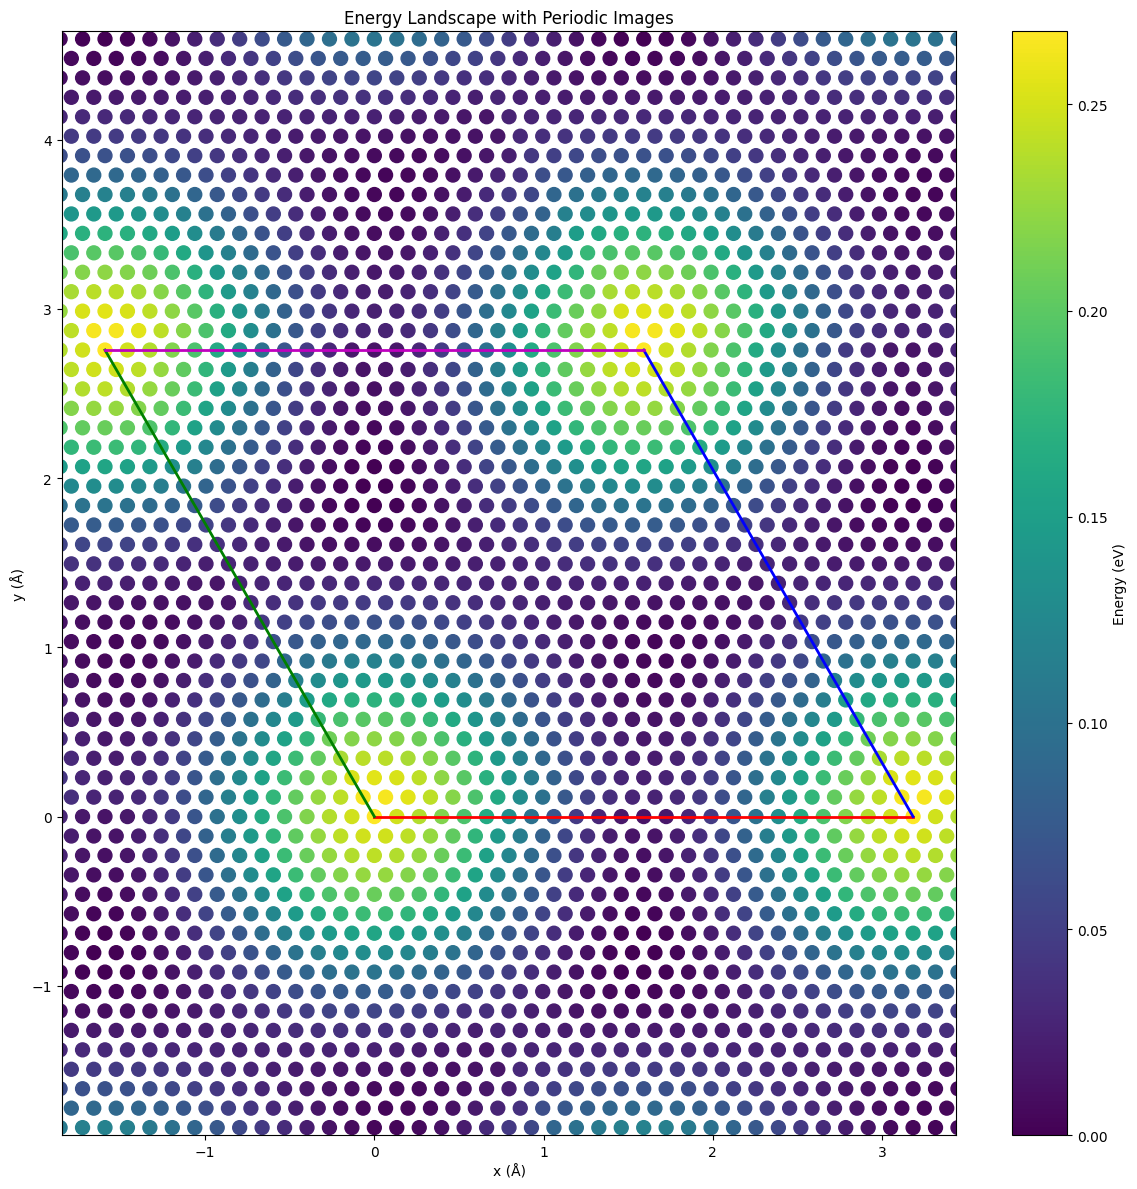

In [8]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt

# Read the dataset
structures = read("bilayer_MoS2_WSe2_config_min_dist_configuration_space.xyz", index=":")
x_y_list = []
for atoms in structures:
    x_y_list.append((atoms.info['a1_shift_cartesian'] + atoms.info['a2_shift_cartesian']))
x_y_list = np.array(x_y_list)
energy_list = []
for atoms in structures:
    energy_list.append(atoms.get_potential_energy())
energy_list = np.array(energy_list) 
energy_list -= np.min(energy_list)

# Get unit cell vectors
a1 = structures[0].info['a1']
a2 = structures[0].info['a2']

# Create a 3x3 grid of periodic images
fig, ax = plt.subplots(figsize=(12, 12))

for i in range(-1, 2):
    for j in range(-1, 2):
        offset = i * a1 + j * a2
        plt.scatter(x_y_list[:,0] + offset[0], x_y_list[:,1] + offset[1], c=energy_list, cmap='viridis', s=100)

# Plot unit cell edges for the center cell
origin = np.array([0, 0])
plt.plot([origin[0], origin[0] + a1[0]], [origin[1], origin[1] + a1[1]], color='r', linewidth=2)
plt.plot([origin[0], origin[0] + a2[0]], [origin[1], origin[1] + a2[1]], color='g', linewidth=2)
plt.plot([origin[0] + a1[0], origin[0] + a1[0] + a2[0]], [origin[1] + a1[1], origin[1] + a1[1] + a2[1]], color='b', linewidth=2)
plt.plot([origin[0] + a2[0], origin[0] + a1[0] + a2[0]], [origin[1] + a2[1], origin[1] + a1[1] + a2[1]], color='m', linewidth=2)

plt.colorbar(label='Energy (eV)')
plt.xlabel('x (Å)')
plt.ylabel('y (Å)')
plt.title('Energy Landscape with Periodic Images')
plt.axis('equal')
# Calculate the limits for the center unit cell
x_min, y_min = np.min([origin, origin + a1, origin + a2, origin + a1 + a2], axis=0)
x_max, y_max = np.max([origin, origin + a1, origin + a2, origin + a1 + a2], axis=0)

# Add a small border (5% of the cell size)
border_x = 0.05 * (x_max - x_min)
border_y = 0.05 * (y_max - y_min)

plt.xlim(x_min - border_x, x_max + border_x)
plt.ylim(y_min - border_y, y_max + border_y)

plt.tight_layout()
plt.show()


In [133]:
import numpy as np
from scipy.spatial import Voronoi, cKDTree
from scipy.optimize import linear_sum_assignment
from scipy.interpolate import RBFInterpolator
from scipy.spatial.distance import cdist

def get_primitive_voronoi_cell(cell):
    x, y = np.meshgrid([-1, 0, 1], [-1, 0, 1])
    points = np.column_stack((x.ravel(), y.ravel()))
    lattice_points = points @ cell
    vor = Voronoi(lattice_points)
    central_point_index = 4
    central_region = vor.regions[vor.point_region[central_point_index]]
    if -1 not in central_region:
        return vor.vertices[central_region]
    return None

def confine_displacement(displacement, actual_cell, pristine_cell):
    actual_centroid = np.mean(actual_cell, axis=0)
    pristine_centroid = np.mean(pristine_cell, axis=0)
    
    actual_cell_centered = actual_cell - actual_centroid
    pristine_cell_centered = pristine_cell - pristine_centroid
    
    # Match vertices between actual and pristine cells
    cost_matrix = cdist(actual_cell_centered, pristine_cell_centered)
    _, col_ind = linear_sum_assignment(cost_matrix)
    
    pristine_cell_matched = pristine_cell[col_ind]
    
    # Create TPS interpolator
    tps = RBFInterpolator(actual_cell, pristine_cell_matched, kernel='thin_plate_spline', smoothing=0)
    
    # Apply TPS to the displacement
    start_point = actual_centroid
    end_point = start_point + displacement
    
    transformed_points = tps(np.vstack((start_point, end_point)))
    confined_displacement = transformed_points[1] - transformed_points[0]
    
    return confined_displacement

def calculate_voronoi_and_displacement(padded_positions, query_points, A1):
    points_2d = padded_positions[:, :2]
    vor = Voronoi(points_2d)
    tree = cKDTree(points_2d)
    
    pristine_cell = get_primitive_voronoi_cell(A1)
    
    _, nearest_indices = tree.query(query_points)
    region_indices = vor.point_region[nearest_indices]
    
    centroids = []
    for region_index in region_indices:
        region = vor.regions[region_index]
        if -1 not in region:
            cell_vertices = vor.vertices[region]
            centroid = np.mean(cell_vertices, axis=0)
        else:
            centroid = points_2d[nearest_indices[len(centroids)]]
        centroids.append(centroid)
    
    centroids = np.array(centroids)
    displacements = query_points - centroids
    
    confined_displacements = np.array([confine_displacement(disp, vor.vertices[vor.regions[region_index]], pristine_cell) 
                                       for disp, region_index in zip(displacements, region_indices)])
    
    return vor, centroids, displacements, confined_displacements

def pad_periodic_image(pos, box):
    """
    Pad the periodic image of a structure in both the a1 and a2 directions to make a 5x5 super cell.
    """
    n_a1, n_a2 = 2, 2  # This will create a 5x5 supercell
    i_range = np.arange(-n_a1, n_a1+1)
    j_range = np.arange(-n_a2, n_a2+1)
    
    i, j = np.meshgrid(i_range, j_range)
    i, j = i.flatten(), j.flatten()
    
    offsets = i[:, np.newaxis] * box[0] + j[:, np.newaxis] * box[1]
    padded_pos = pos[np.newaxis, :, :] + offsets[:, np.newaxis, :]
    
    return padded_pos.reshape(-1, 2)

def calculate_displacements(structures, A1):
    confined_displacements = []
    energies = []
    pristine_cell = get_primitive_voronoi_cell(A1)

    for atoms in structures:
        # Get positions of both layers
        layer1_pos = atoms.positions[atoms.arrays['atom_types'] == 0, :2]
        layer2_pos = atoms.positions[atoms.arrays['atom_types'] == 3, :2]
        # print(atoms.info['a1_shift_cartesian'])
        false_periodic_image = np.array([atoms.info['a1'],atoms.info['a2']])
        # print(false_periodic_image, A1)

        # Pad the periodic image of layer 2
        padded_layer2_pos = pad_periodic_image(layer2_pos,false_periodic_image)
        
        # Calculate Voronoi and displacement
        vor, centroids, displacements, conf_displacements = calculate_voronoi_and_displacement(padded_layer2_pos, layer1_pos, A1)

        # Create 3x3 periodic images of the confined displacements
        padded_displacements = pad_periodic_image(conf_displacements, false_periodic_image)

        confined_displacements.extend(padded_displacements)
        energies.extend([atoms.get_potential_energy()] * len(padded_displacements))

    return np.array(confined_displacements), np.array(energies)


# Read the dataset
structures = read("bilayer_MoS2_WSe2_config_configuration_space.xyz", index=":")

# Get A1 lattice vector and pristine cell
# A1 = structures[0].cell[:2, :2]
pristine_cell = get_primitive_voronoi_cell(A1)
centroid = np.mean(pristine_cell, axis=0)

# Extract data and calculate confined displacements
confined_displacements = []
energies = []

# for atoms in structures:
#     x = atoms.info['a1_shift_cartesian'][0] + atoms.info['a2_shift_cartesian'][0]
#     y = atoms.info['a1_shift_cartesian'][1] + atoms.info['a2_shift_cartesian'][1]
#     displacement = np.array([x, y])
    
#     # Calculate the actual Voronoi cell for this configuration
#     actual_cell = get_primitive_voronoi_cell(atoms.cell[:2, :2])
    
#     confined_displacement = confine_displacement(displacement, actual_cell, pristine_cell)
    
#     false_periodic_image = np.array([atoms.info['a1'],atoms.info['a2']])
    
#     # Create 3x3 periodic images of the confined displacement
#     padded_displacements = pad_periodic_image(confined_displacement[np.newaxis, :], false_periodic_image)
    
#     confined_displacements.extend(padded_displacements)
#     energies.extend([atoms.get_potential_energy()] * len(padded_displacements))

# confined_displacements = np.array(confined_displacements)
# energies = np.array(energies)

confined_displacements, energies = calculate_displacements(structures, A1)

# Normalize energies
energies -= np.min(energies)

# ... (rest of the plotting code remains the same)

# Create a grid for interpolation (expand to cover 5x5 supercell)
x = np.linspace(centroid[0] - 1.5*np.linalg.norm(A1[0]), centroid[0] + 1.5*np.linalg.norm(A1[0]), 200)
y = np.linspace(centroid[1] - 1.5*np.linalg.norm(A1[1]), centroid[1] + 1.5*np.linalg.norm(A1[1]), 200)
X, Y = np.meshgrid(x, y)
grid_points = np.column_stack((X.ravel(), Y.ravel()))

# Interpolate energies
rbf = RBFInterpolator(confined_displacements + centroid, energies, kernel='thin_plate_spline', smoothing=0.5)
interpolated_energies = rbf(grid_points)

# Reshape for plotting
Z = interpolated_energies.reshape(X.shape)

# Create the figure
fig, ax = plt.subplots(figsize=(10, 10))

# # Plot interpolated energy landscape
im = ax.imshow(Z, extent=[x.min(), x.max(), y.min(), y.max()], 
               origin='lower', cmap='viridis', aspect='equal')

# Plot Voronoi cell
for i in [-1, 0, 1]:
    for j in [-1, 0, 1]:
        offset = i * A1[0] + j * A1[1]
        cell = pristine_cell + offset
        ax.plot(np.append(cell[:, 0], cell[0, 0]),
                np.append(cell[:, 1], cell[0, 1]), 'k-', linewidth=1, alpha=0.5)

# # Plot confined displacements
scatter = ax.scatter(confined_displacements[:, 0] + centroid[0], 
                     confined_displacements[:, 1] + centroid[1], 
                     c=energies, cmap='viridis', s=20, edgecolors='w', linewidths=0.5)

# Set the limits to show the central 1x1 Voronoi cell
ax.set_xlim(centroid[0] - 1.5*np.linalg.norm(A1[0]), centroid[0] + 1.5*np.linalg.norm(A1[0]))
ax.set_ylim(centroid[1] - 1.5*np.linalg.norm(A1[1]), centroid[1] + 1.5*np.linalg.norm(A1[1]))

# Add labels and title
ax.set_title('Interpolated Energy Landscape with Confined Displacements', fontsize=16)
ax.set_xlabel('x (Å)', fontsize=14)
ax.set_ylabel('y (Å)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add colorbar
# cbar = plt.colorbar(im, ax=ax)
# cbar.set_label('Energy (eV)', fontsize=14)
# cbar.ax.tick_params(labelsize=12)
# plt.axis('scaled')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

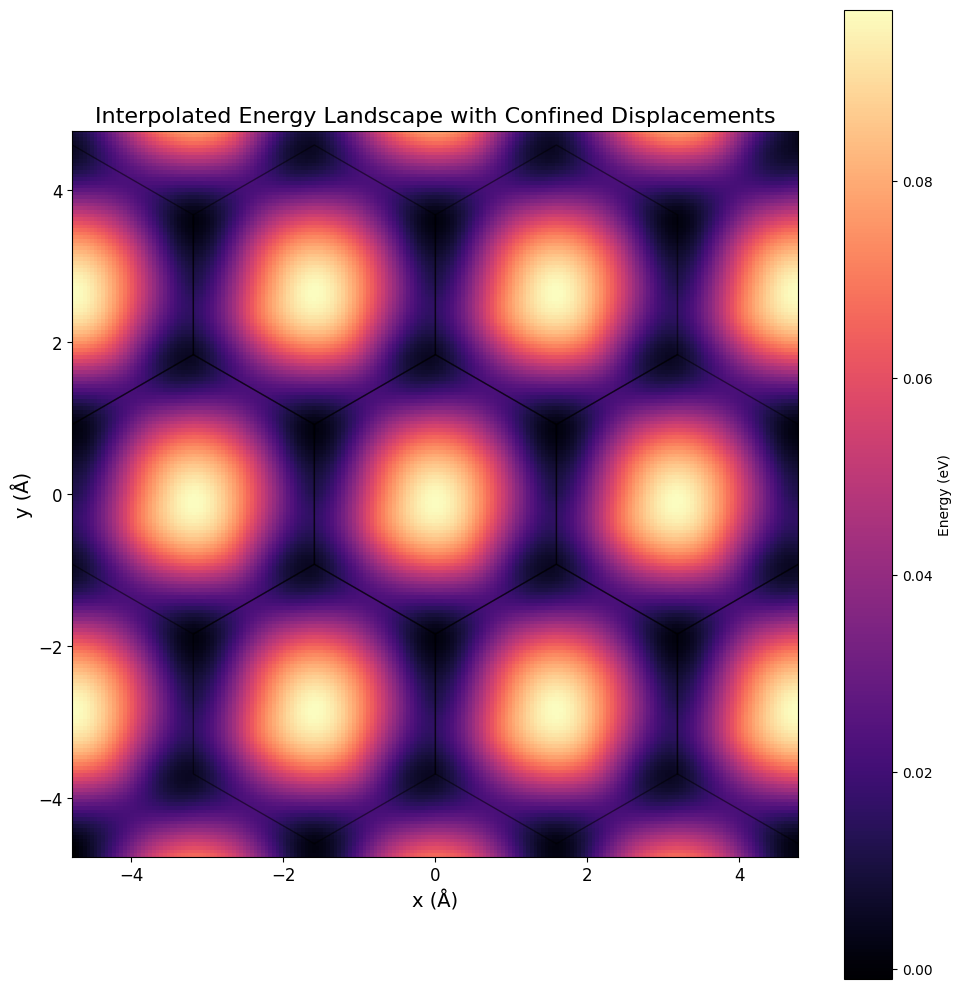

In [36]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, cKDTree
from scipy.optimize import linear_sum_assignment
from scipy.interpolate import RBFInterpolator
from scipy.spatial.distance import cdist

def get_primitive_voronoi_cell(cell):
    """Calculate the primitive Voronoi cell for a given lattice."""
    x, y = np.meshgrid([-1, 0, 1], [-1, 0, 1])
    points = np.column_stack((x.ravel(), y.ravel()))
    lattice_points = points @ cell
    vor = Voronoi(lattice_points)
    central_point_index = 4  # Center point in 3x3 grid
    central_region = vor.regions[vor.point_region[central_point_index]]
    return vor.vertices[central_region] if -1 not in central_region else None

def confine_displacement(displacement, actual_cell, pristine_cell):
    """Confine a displacement vector to the pristine Voronoi cell using thin plate spline interpolation."""
    actual_centroid = np.mean(actual_cell, axis=0)
    pristine_centroid = np.mean(pristine_cell, axis=0)
    
    # Center cells
    actual_cell_centered = actual_cell - actual_centroid
    pristine_cell_centered = pristine_cell - pristine_centroid
    
    # Match vertices between actual and pristine cells
    cost_matrix = cdist(actual_cell_centered, pristine_cell_centered)
    _, col_ind = linear_sum_assignment(cost_matrix)
    pristine_cell_matched = pristine_cell[col_ind]
    
    # Create and apply TPS interpolator
    tps = RBFInterpolator(actual_cell, pristine_cell_matched, kernel='thin_plate_spline', smoothing=0)
    start_point, end_point = actual_centroid, actual_centroid + displacement
    transformed_points = tps(np.vstack((start_point, end_point)))
    
    return transformed_points[1] - transformed_points[0]

def pad_periodic_image(pos, box, n=2):
    """Create a padded periodic image of the structure."""
    i_range = j_range = np.arange(-n, n+1)
    i, j = np.meshgrid(i_range, j_range)
    i, j = i.flatten(), j.flatten()
    
    offsets = i[:, np.newaxis] * box[0] + j[:, np.newaxis] * box[1]
    padded_pos = pos[np.newaxis, :, :] + offsets[:, np.newaxis, :]
    
    return padded_pos.reshape(-1, 2)

def calculate_displacements(structures, A1):
    """Calculate confined displacements for all structures."""
    confined_displacements = []
    energies = []
    pristine_cell = get_primitive_voronoi_cell(A1)

    for atoms in structures:
        layer1_pos = atoms.positions[atoms.arrays['atom_types'] == 0, :2]
        layer2_pos = atoms.positions[atoms.arrays['atom_types'] == 3, :2]
        false_periodic_image = np.array([atoms.info['a1'], atoms.info['a2']])

        padded_layer2_pos = pad_periodic_image(layer2_pos, false_periodic_image)
        
        # Calculate Voronoi and displacement
        vor = Voronoi(padded_layer2_pos)
        tree = cKDTree(padded_layer2_pos)
        _, nearest_indices = tree.query(layer1_pos)
        region_indices = vor.point_region[nearest_indices]
        
        centroids = []
        for region_index in region_indices:
            region = vor.regions[region_index]
            if -1 not in region:
                cell_vertices = vor.vertices[region]
                centroid = np.mean(cell_vertices, axis=0)
            else:
                centroid = padded_layer2_pos[nearest_indices[len(centroids)]]
            centroids.append(centroid)
        
        centroids = np.array(centroids)
        displacements = layer1_pos - centroids
        
        conf_displacements = np.array([confine_displacement(disp, vor.vertices[vor.regions[region_index]], pristine_cell) 
                                       for disp, region_index in zip(displacements, region_indices)])

        # Create periodic images of the confined displacements
        padded_displacements = pad_periodic_image(conf_displacements, false_periodic_image)

        confined_displacements.extend(padded_displacements)
        energies.extend([atoms.get_potential_energy()] * len(padded_displacements))

    return np.array(confined_displacements), np.array(energies)

def plot_energy_landscape(confined_displacements, energies, A1, pristine_cell):
    """Plot the interpolated energy landscape with confined displacements."""
    centroid = np.mean(pristine_cell, axis=0)
    
    # Create a grid for interpolation
    x = np.linspace(centroid[0] - 1.5*np.linalg.norm(A1[0]), centroid[0] + 1.5*np.linalg.norm(A1[0]), 200)
    y = np.linspace(centroid[1] - 1.5*np.linalg.norm(A1[1]), centroid[1] + 1.5*np.linalg.norm(A1[1]), 200)
    X, Y = np.meshgrid(x, y)
    grid_points = np.column_stack((X.ravel(), Y.ravel()))

    # Interpolate energies
    rbf = RBFInterpolator(confined_displacements + centroid, energies, kernel='thin_plate_spline', smoothing=0.1)
    interpolated_energies = rbf(grid_points).reshape(X.shape)

    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot interpolated energy landscape
    im = ax.imshow(interpolated_energies, extent=[x.min(), x.max(), y.min(), y.max()], 
                   origin='lower', cmap='magma', aspect='equal')

    # Plot Voronoi cell
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            offset = i * A1[0] + j * A1[1]
            cell = pristine_cell + offset
            ax.plot(np.append(cell[:, 0], cell[0, 0]),
                    np.append(cell[:, 1], cell[0, 1]), 'k-', linewidth=1, alpha=0.5)

    # Plot confined displacements
    # scatter = ax.scatter(confined_displacements[:, 0] + centroid[0], 
    #                      confined_displacements[:, 1] + centroid[1], 
    #                      c=energies, cmap='viridis', s=20, edgecolors='w', linewidths=0.5)

    # Set the limits to show the central 3x3 Voronoi cells
    ax.set_xlim(centroid[0] - 1.5*np.linalg.norm(A1[0]), centroid[0] + 1.5*np.linalg.norm(A1[0]))
    ax.set_ylim(centroid[1] - 1.5*np.linalg.norm(A1[1]), centroid[1] + 1.5*np.linalg.norm(A1[1]))

    # Add labels and title
    ax.set_title('Interpolated Energy Landscape with Confined Displacements', fontsize=16)
    ax.set_xlabel('x (Å)', fontsize=14)
    ax.set_ylabel('y (Å)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.colorbar(im, ax=ax, label='Energy (eV)')
    plt.tight_layout()
    plt.show()
    
    
 # Read the dataset
structures = read("bilayer_MoS2_WSe2_config_configuration_space.xyz", index=":")

# Get A1 lattice vector and pristine cell
# A1 = structures[0].cell[:2, :2]
pristine_cell = get_primitive_voronoi_cell(A1)

# Calculate confined displacements and energies
confined_displacements, energies = calculate_displacements(structures, A1)

# Normalize energies
energies -= np.min(energies)

# Plot the energy landscape
plot_energy_landscape(confined_displacements, energies, A1, pristine_cell)

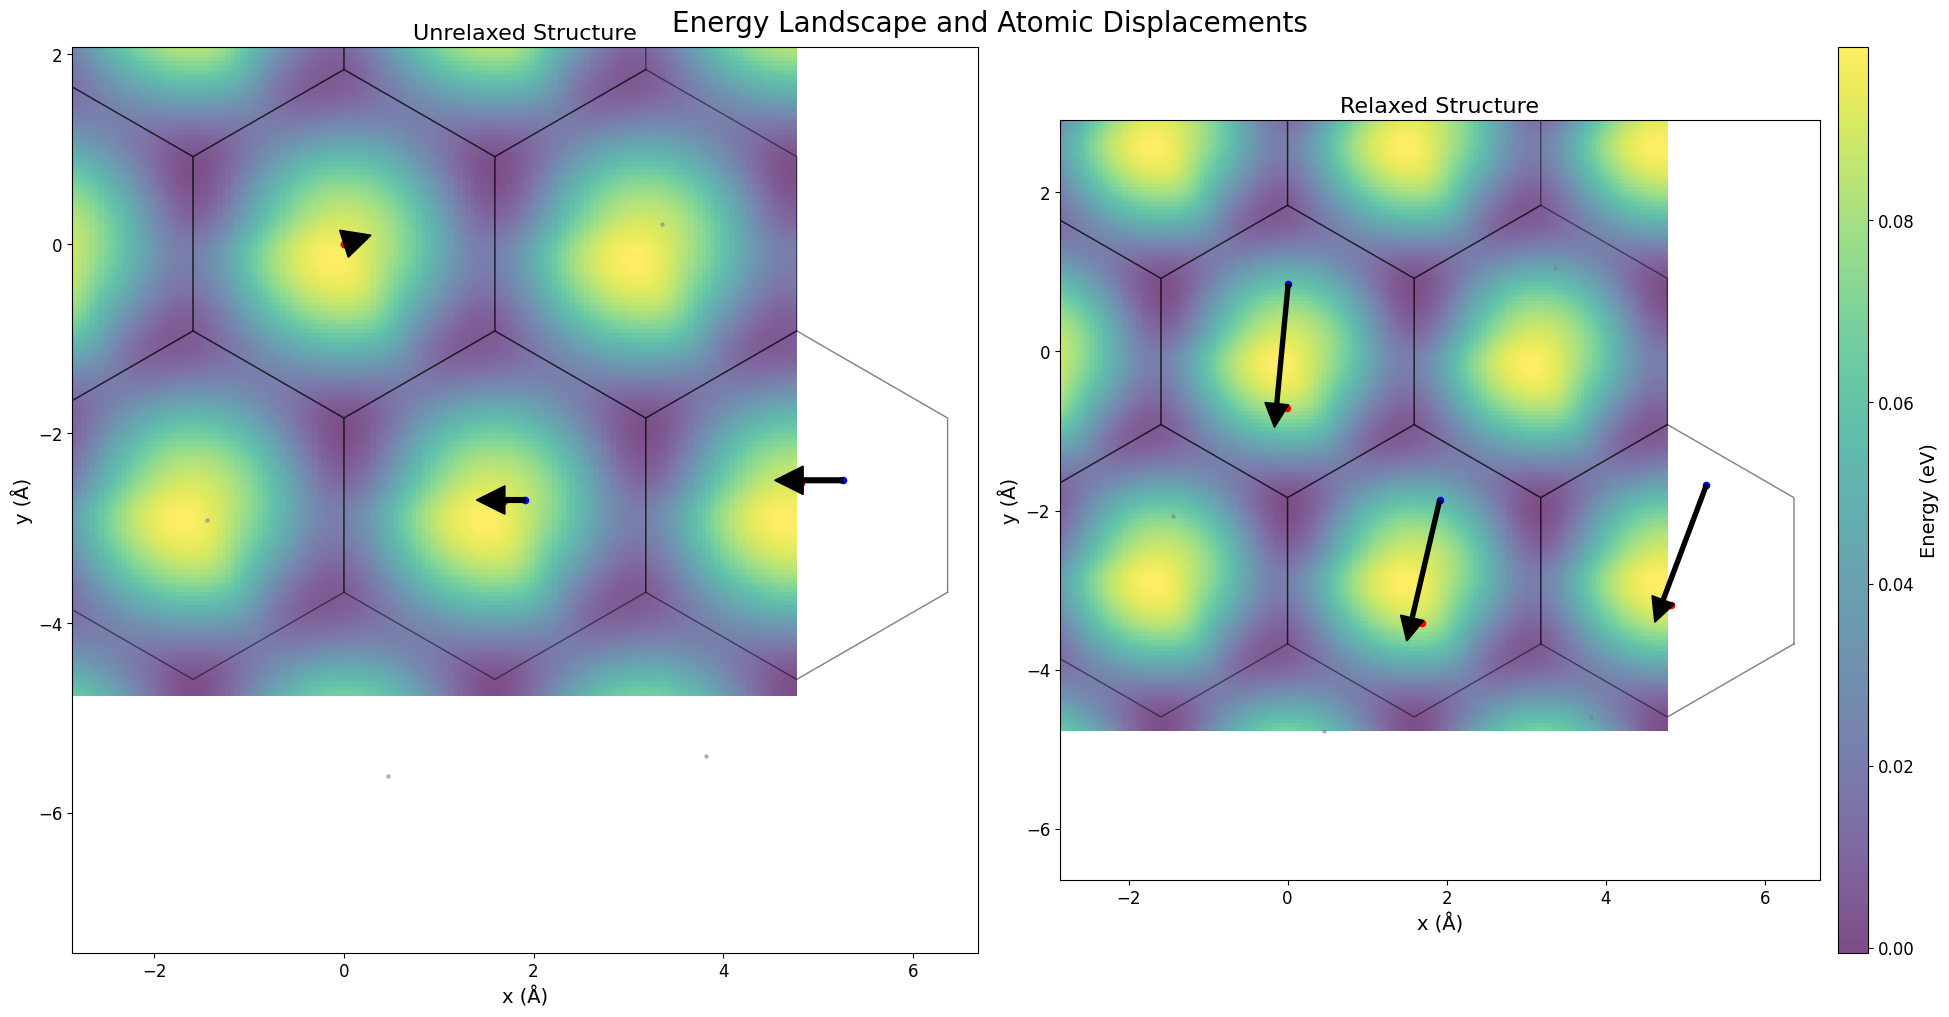

In [136]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, cKDTree
from scipy.optimize import linear_sum_assignment
from scipy.interpolate import RBFInterpolator
from scipy.spatial.distance import cdist
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

# ... (include all the functions from both scripts here) ...

def combined_visualization(structures, A1):
    # Calculate energy landscape
    pristine_cell = get_primitive_voronoi_cell(A1)
    confined_displacements, energies = calculate_displacements(structures, A1)
    energies -= np.min(energies)
    
    # Create a grid for interpolation
    centroid = np.mean(pristine_cell, axis=0)
    x = np.linspace(centroid[0] - 1.5*np.linalg.norm(A1[0]), centroid[0] + 1.5*np.linalg.norm(A1[0]), 200)
    y = np.linspace(centroid[1] - 1.5*np.linalg.norm(A1[1]), centroid[1] + 1.5*np.linalg.norm(A1[1]), 200)
    X, Y = np.meshgrid(x, y)
    grid_points = np.column_stack((X.ravel(), Y.ravel()))

    # Interpolate energies
    rbf = RBFInterpolator(confined_displacements + centroid, energies, kernel='thin_plate_spline', smoothing=0.5)
    interpolated_energies = rbf(grid_points).reshape(X.shape)

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    for ax, structure, title in zip([ax1, ax2], [unrelaxed, relaxed], ['Unrelaxed', 'Relaxed']):
        # Plot energy landscape
        im = ax.imshow(interpolated_energies, extent=[x.min(), x.max(), y.min(), y.max()], 
                       origin='lower', cmap='viridis', aspect='equal', alpha=0.7)

        # Plot Voronoi cell
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                offset = i * A1[0] + j * A1[1]
                cell = pristine_cell + offset
                ax.plot(np.append(cell[:, 0], cell[0, 0]),
                        np.append(cell[:, 1], cell[0, 1]), 'k-', linewidth=1, alpha=0.5)

        # Calculate displacements
        padded_pos = pad_periodic_image(structure.positions[structure.arrays['atom_types'] == 3,:2], structure.cell[:2,:2])
        query_points = structure.positions[structure.arrays['atom_types'] == 0,:2]
        vor, centroids, displacements, confined_displacements = calculate_voronoi_and_displacement(padded_pos, query_points, A1)

        # Plot atomic positions and displacements
        ax.scatter(padded_pos[:,0], padded_pos[:,1], s=5, alpha=0.5, color='gray')
        ax.scatter(structure.positions[structure.arrays['atom_types'] == 3,0], 
                   structure.positions[structure.arrays['atom_types'] == 3,1], s=20, color='blue')
        ax.scatter(query_points[:,0], query_points[:,1], s=20, color='red')

        for centroid, query_point, displacement in zip(centroids, query_points, confined_displacements):
            ax.arrow(centroid[0], centroid[1], displacement[0], displacement[1], 
                     head_width=0.3, head_length=0.3, fc='k', ec='k', width=0.05)

        ax.set_xlim(centroid[0] - 1.5*np.linalg.norm(A1[0]), centroid[0] + 1.5*np.linalg.norm(A1[0]))
        ax.set_ylim(centroid[1] - 1.5*np.linalg.norm(A1[1]), centroid[1] + 1.5*np.linalg.norm(A1[1]))
        ax.set_title(f'{title} Structure', fontsize=16)
        ax.set_xlabel('x (Å)', fontsize=14)
        ax.set_ylabel('y (Å)', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax2, aspect=30, pad=0.02)
    cbar.set_label('Energy (eV)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    fig.suptitle('Energy Landscape and Atomic Displacements', fontsize=20)
    plt.tight_layout()
    plt.show()

# Main execution
structures = read("bilayer_MoS2_WSe2_config_configuration_space.xyz", index=":")
unrelaxed = read("MoS2_WSe2_1D.xyz", index=0)
relaxed = read("MoS2_WSe2_1D_lammps.traj.xyz", index=-1)
relaxed.arrays['atom_types'] = unrelaxed.arrays['atom_types']

# Define A1 and A2 unit cells (replace with your actual unit cell matrices)
def convert_string_to_array(string):
    # Remove brackets and split the string into components
    return np.array([float(x) for x in string.strip('[]').split()]).reshape(2,2)
A1 = convert_string_to_array(unrelaxed.info['base_lattice_0'])
A2 = convert_string_to_array(unrelaxed.info['base_lattice_1'])


combined_visualization(structures, A1)

(np.float64(-1.7883450995169456),
 np.float64(1.7883450995169454),
 np.float64(-2.065003049220113),
 np.float64(2.065003049220113))

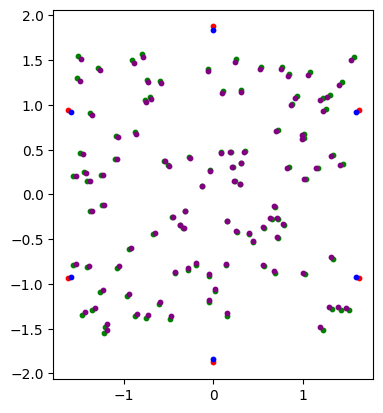

In [108]:
x = atoms.info['a1_shift_cartesian'][0] + atoms.info['a2_shift_cartesian'][0]
y = atoms.info['a1_shift_cartesian'][1] + atoms.info['a2_shift_cartesian'][1]
displacement = np.array([x, y])

actual_cell = get_primitive_voronoi_cell(atoms.cell[:2, :2]) 
pristine_cell = get_primitive_voronoi_cell(A1)
random_test_points = (np.random.rand(100, 2) - 0.5) * np.linalg.norm(A1, axis=1)
confined_displacements = np.array([confine_displacement(random_test_point, actual_cell, pristine_cell) for random_test_point in random_test_points])
# Plot the actual cell
plt.scatter(actual_cell[:, 0], actual_cell[:, 1], c='red', s=10)
plt.scatter(pristine_cell[:, 0], pristine_cell[:, 1], c='blue', s=10)
plt.scatter(random_test_points[:, 0], random_test_points[:, 1], c='green', s=10)
plt.scatter(confined_displacements[:, 0], confined_displacements[:, 1], c='purple', s=10)
plt.axis('scaled')



In [113]:
atoms.info

{'a1_shift_crystal': np.float64(0.9166666666666666),
 'a2_shift_crystal': np.float64(0.9166666666666666),
 'a1_shift_cartesian': array([2.91875833, 0.        ]),
 'a2_shift_cartesian': array([-1.45933333,  2.52770833]),
 'a1': array([3.1841, 0.    ]),
 'a2': array([-1.592 ,  2.7575]),
 'total_shift': array([1.459425  , 2.52770833]),
 'layer_energy': array([[-3.60357625, -0.15146699],
        [ 0.        , -7.9992407 ]]),
 'il_dist': np.float64(6.852183149589731)}

In [72]:
np.linalg.norm(actual_cell, axis=1)

array([1.8772755, 1.8772755, 1.8772755, 1.8772755, 1.8772755, 1.8772755])

In [ ]:
plt.scatter()